In [5]:
# importing Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from datetime import datetime
import threading

In [2]:
#Read in Tickers
df = pd.read_csv("Tickers.csv")

In [3]:
#If column name is a ticker, we make the column name into a ticker
first_ticker = df.columns[0]

In [4]:
#Rename Columns Properly
df.rename(columns = {first_ticker:"ticker"},inplace=True)

In [5]:
#Filter based on if regularMarketPrice exists for a certain stock or not
ab = yf.Ticker(first_ticker)
if ab.info["regularMarketPrice"] != None:
    df = df.append({"ticker":first_ticker},ignore_index=True)

In [6]:
# Remove any duplicates from the list
df = pd.DataFrame(list(dict.fromkeys(df.ticker)))

In [7]:
# renaming column names
df.rename(columns = {0:"ticker"},inplace=True)
df

,ticker
0,ABBV
1,ABT
2,ACN
3,AGN
4,AIG
...,...
57,UNH
58,UNP
59,UPS
60,USB


In [8]:
#Get length of dataframe
length = len(df)

In [9]:
## Downloading all the prices from yfinance at once
data = yf.download(  # or pdr.get_data_yahoo(...
        tickers = list(df.ticker),
        period = "5y",
        group_by = 'ticker',
        auto_adjust = True,
        threads = True,
        proxy = None)

[*********************100%***********************]  62 of 62 completed

4 Failed downloads:
- RTN: No data found, symbol may be delisted
- CELG: No data found, symbol may be delisted
- AGN: No data found, symbol may be delisted
- PCLN: None


In [10]:
# Function to download info from yfinance of ticker list 
inf = {}
l = 0
def get_info(ticker,start,end):
    global l
    for tick in ticker[start:end]:
        info = yf.Ticker(tick).info
        inf[tick] = info
        l+=100/length
        print("\rCompleted ",round(l,2),"%",end="")

In [11]:
# Multithreading Function to make the code more effecient
def split_processing(items,func, num_splits=20,split_size=100):                                      
    try:
        split_size = len(items) // num_splits 
    except:
        pass
    threads = []                                                                
    for i in range(num_splits):                                                 
        # determine the indices of the list this thread will handle             
        start = i * split_size                                                  
        # special case on the last chunk to account for uneven splits           
        end = None if i+1 == num_splits else (i+1) * split_size                 
        # create the thread                                                     
        threads.append(                                                         
            threading.Thread(target=func, args=(items,start,end)))         
        threads[-1].start() # start the thread we just created                  

    # wait for all threads to finish                                            
    for t in threads:                                                           
        t.join()
    print("\rCompleted", 100.00,"%",end="")

In [12]:
# Using Multithreading to download the info.
split_processing(df.ticker,get_info)

Completed  100.0 % 82.26 % 90.32 %

In [13]:
#Check for delisted and non-existent stocks and creating a dictionary by combining all the data together for future use.
start_date = "2017-01-01"
dict2 = {}
pct = 0
global inf
for i in df.ticker:
    info = inf[i]
    a = data[i][data[i].index >= datetime.fromisoformat(start_date)]
    if a.Close.index.size > 0:
        dict2[i] = {"info":info,"price":a}
    pct+=100/length
    print("Completed", round(pct,2),"%",end="\r")

In [14]:
# Filter stocks based on currency and average share volume
filtered_stock_data = {}
for i,j in dict2.items():
    try:
        if j["info"]["currency"] == "USD" and np.mean(j["price"]["Volume"]) > 10000:
            filtered_stock_data[i]=j
        else:
            pass
    except KeyError:
        pass
len(filtered_stock_data)

55

In [15]:
#Calculate std of stock
def std_stock(stock):
    close=stock['price']['Close']
    std=close.pct_change().std()
    return std

In [16]:
#Create new dictionary with Ticker & STD of ticker using the std_stock func
dict3={}
for i,j in filtered_stock_data.items():
    dict3[i]= std_stock(j)
    
dict3

{'ABBV': 0.017565477713722223,
 'ABT': 0.015566008080415973,
 'ACN': 0.015488414016176361,
 'AIG': 0.023951829775707083,
 'AMZN': 0.01845392899466147,
 'AXP': 0.02146437205014576,
 'BA': 0.029437587037962672,
 'BAC': 0.02117376744997373,
 'BIIB': 0.029550362272822695,
 'BK': 0.018353452614007802,
 'BLK': 0.01799754637352185,
 'BMY': 0.015466871114794832,
 'C': 0.022991058372361522,
 'CAT': 0.019562961004530276,
 'CL': 0.012969902812909629,
 'CMCSA': 0.01667238419388562,
 'COF': 0.024740442707894335,
 'COP': 0.026235163696943897,
 'COST': 0.01329820742491586,
 'CSCO': 0.016957424158532422,
 'CVS': 0.017698906191439108,
 'GM': 0.023760311556050417,
 'GOOG': 0.01690841382696549,
 'JPM': 0.018877373772347012,
 'KMI': 0.0196930017050867,
 'KO': 0.012541466005150015,
 'LLY': 0.017429110767244637,
 'LMT': 0.015558329134340163,
 'MO': 0.015923452547318192,
 'MON': 0.004594132392755029,
 'MRK': 0.014062099052117897,
 'MS': 0.02127089199706426,
 'MSFT': 0.017173095239746947,
 'NEE': 0.0149213933

In [17]:
#We create a function to sort and get the 15 least std values with keys
#n smallest standard deviation from dictionary
list_nsmallest = []
temp_dict = dict3.copy()
while True:
    temp = min(temp_dict.values())
    res = [key for key in temp_dict if temp_dict[key] == temp]
    list_nsmallest.append(res[0])
    temp_dict.pop(res[0])
    if len(list_nsmallest) == 15:
        break

### Why we want low standard deviation:



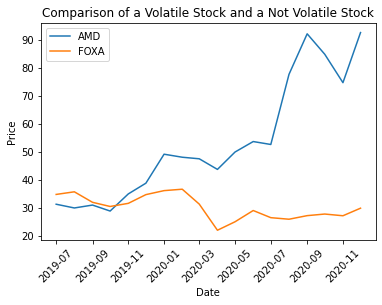

In [6]:
High_Volatile_Ticker = yf.Ticker('AMD')
Low_Volatile_Ticker = yf.Ticker('FOXA')
start_date = '2019-07-01'
end_date = '2021-01-01'

high = High_Volatile_Ticker.history(start = start_date, end = end_date)
low = Low_Volatile_Ticker.history(start = start_date, end = end_date)

Compare = pd.DataFrame()
Compare['AMD'] = high['Close']
Compare['FOXA'] = low['Close']
monethly_prices = Compare.resample('MS').first()

plt.plot(monethly_prices['AMD'], label="AMD")
plt.plot(monethly_prices['FOXA'], label="FOXA")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of a Volatile Stock and a Not Volatile Stock")
plt.xticks(rotation=45)

plt.legend(loc="upper left")
plt.show()

In [7]:
print( monethly_prices['AMD'].std())

21.67161817007647


In [8]:
print( monethly_prices['FOXA'].std())

4.256999893845997


This is an example of why the standard deviation should be taken under consideration. Take AMD, it is rated the most volatile stock in 2019, and FOXA, one of the least volatile stocks in 2019. When we overlap the 2 stocks during 2019, we can see just how much more volatile AMD is compared to FOXA. Theoretically, a stock with a high volatility should have a higher standard deviation than one with less volatility. This is seen to be true in the case of comparing AMD and FOXA, as the standard deviation of the closing price of AMD in 2019 is a lot higher than that of FOXA. 
With this in mind, we will want to choose the stocks with the least standard deviation so that the stocks are as less volatile as possible following our plan to make the safest portfolio. 

In [18]:
res=list_nsmallest

In [19]:
res

['MON',
 'KO',
 'PG',
 'CL',
 'PEP',
 'COST',
 'MRK',
 'PFE',
 'T',
 'NEE',
 'BMY',
 'ACN',
 'SO',
 'LMT',
 'ABT']

In [20]:
# All possible combinations of 10 stocks out of 15
def combinations(lst, depth, start=0, items=[]):
    if depth <= 0:
        return [items]
    out = []
    for i in range(start, len(lst)):
        out += combinations(lst, depth - 1, i + 1, items + [lst[i]])
    return out

In [21]:
comb = combinations(res, 10)

### Covariance

Covariance provides a measure of the strength of the correlation between two variables.

\begin{align*}
COV(X,Y)=\frac{\sum(x_i-\overline{X})\times(y_i-\overline{Y})}{N}
\end{align*}

### Correlation

Correlation is a pair wise concept use to determine the relation (strength) between two assets, it takes a standardised value between $-1$ and $1$

\begin{align*}
COR(X,Y)=\frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
\end{align*}

### Our idea of Calculating Correlation of the portfolio
Suppose a portfolio have 4 stocks W,X,Y,Z. We calculate correlation of each stock with the stock before and after and average out the sum of correlations by dividing with the toatl number of stocks.


\begin{align*}
COR(Portfolio)=\frac{COR(W,X)+COR(X,Y)+COR(Y,Z)+COR(Z,W)}{4}
\end{align*}


This method helps us determine the correlation of a particular portfolio

### Why we want the lowest correlation possible of our portfolio

Lets compare a portfolio with stocks that are negativly correlated and one with positively correlated stocks

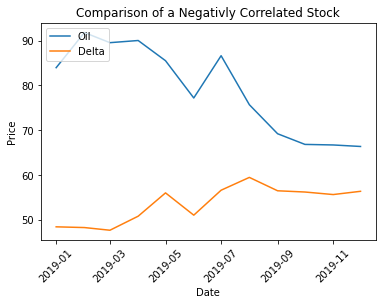

In [10]:
Oil_Ticker = yf.Ticker('EOG')
Airline_Ticker = yf.Ticker('DAL')

start_date2 = '2019-01-01'
end_date2 = '2020-01-01'

oil = Oil_Ticker.history(start = start_date2, end = end_date2)
airline = Airline_Ticker.history(start = start_date2, end = end_date2)

Compare2 = pd.DataFrame()
Compare2['Oil'] = oil['Close']
Compare2['Delta'] = airline['Close']
monethly_prices2 = Compare2.resample('MS').first()

plt.plot(monethly_prices2['Oil'], label="Oil")
plt.plot(monethly_prices2['Delta'], label="Delta")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of a Negativly Correlated Stock")
plt.xticks(rotation=45)

plt.legend(loc="upper left")
plt.show()


In [11]:
monethly_prices2.corr()

,Oil,Delta
Oil,1.000000,-0.637568
Delta,-0.637568,1.000000


if we were to spend 100000 on both stocks at 2014 and sell at 2016

In [13]:
num_of_stock1 = 100000 / oil['Close'].iloc[0]
num_of_stock1

1191.0426093603417

In [14]:
num_of_stock2 = 100000 / airline['Close'].iloc[0]
num_of_stock2

2064.797612514748

In [15]:
final_return = (((num_of_stock1 * oil['Close'].iloc[-1]) + (num_of_stock2 * airline['Close'].iloc[-1]))-200000)/200000*100
final_return

6.72636390414121

In this example, we found 2 negatively correlated stocks at a certain time period. We observe the the absolute value of final percentage return is fairly low, which is what we want in a safe portfolio. 

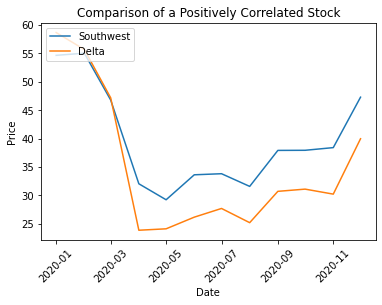

In [17]:
Airline_Ticker1 = yf.Ticker('LUV')
Airline_Ticker2 = yf.Ticker('DAL')

start_date2 = '2020-01-01'
end_date2 = '2021-01-01'

airline2 = Airline_Ticker2.history(start = start_date2, end = end_date2)
airline1 = Airline_Ticker1.history(start = start_date2, end = end_date2)

Compare3 = pd.DataFrame()
Compare3['Southwest'] = airline1['Close']
Compare3['Delta'] = airline2['Close']
monethly_prices3 = Compare3.resample('MS').first()

plt.plot(monethly_prices3['Southwest'], label="Southwest")
plt.plot(monethly_prices3['Delta'], label="Delta")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Comparison of a Positively Correlated Stock")
plt.xticks(rotation=45)

plt.legend(loc="upper left")
plt.show()


In [18]:
monethly_prices3.corr()

,Southwest,Delta
Southwest,1.000000,0.977593
Delta,0.977593,1.000000


In [19]:
num_of_stock3 = 100000 / airline1['Close'].iloc[0]
num_of_stock3

1830.5044647804345

In [20]:
num_of_stock4 = 100000 / airline2['Close'].iloc[0]
num_of_stock4

1705.4716151696568

In [21]:
final_return2 = (((num_of_stock3 * airline1['Close'].iloc[-1]) + (num_of_stock4 * airline2['Close'].iloc[-1]))-200000)/200000*100
final_return2

-23.051586847383355

In this example, we found 2 positively correlated stocks at a certain time period. We observe the absolute value of final percentage return is fairly high, which is not what we want in our safe portfolio

From our observation, having a negativly correlated portfolio means that the losses or gains will be minimized as when prices fall in one stock, they will rise in another. Thus, it is safest to make sure that the correlation of our portfolio be as low as possible.

### Correlation for creating a Safe portfolio

In [22]:
#Function that checks correlation of all pairs and outputs a list of least correlated stocks so portfolio is as less volatile as possible
n=0
min1=10
a=[]
ans=None
comb_length = len(comb)
def corr_calc(comb,start,stop):
    global a
    global ans
    global n
    global min1
    for i in list(comb[start:stop]):
        for j in range(len(i)):
            b=[]
            if j == len(i)-1:
                monthly_returns_1 = dict2[i[j]]['price']['Close'].resample('MS').first()
                monthly_returns_2 = dict2[i[0]]['price']['Close'].resample('MS').first()
                b.append(pd.concat([monthly_returns_1,monthly_returns_2],join="inner",axis=1).corr().iat[0,1])
            else:
                monthly_returns_1 = dict2[i[j]]['price']['Close'].resample('MS').first().pct_change()
                monthly_returns_2 = dict2[i[j+1]]['price']['Close'].resample('MS').first().pct_change()
                b.append(pd.concat([monthly_returns_1,monthly_returns_2],join="inner",axis=1).corr().iat[0,1])
        avg = sum(b)/10
        if avg <= min1:
            min1 = avg
            n+=100/comb_length
    #         print(min1, i, n)
            print("\rCompleted", round(n,2),"%",end="")
            ans=i
        else:
            n+=100/comb_length
#             print("Completed", round(n,2),"%",end="\r")
    #         print(avg, n)
        a.append(avg)
    print("\rCompleted", 100.00,"%",end="")
ans

In [23]:
split_processing(comb,corr_calc,num_splits=30)

Completed 100.0 %100.0 %89.28 %

In [24]:
# sorting the the best 10 Stocks based on their standard deviation.
dict_with_std = {}
for i in ans:
    dict_with_std[i] = dict3[i]
sorted_x = dict(sorted(dict_with_std.items(), key=lambda x: x[1]))
sorted_final_list = list(sorted_x.keys())
sorted_final_list

['MON', 'PG', 'CL', 'PEP', 'COST', 'MRK', 'PFE', 'T', 'NEE', 'BMY']

In [25]:
# Creating Dataframe of all closing prices of stocks
#Creating date variables
starting='2017-01-01'
now=datetime.now()
buy_on_date = now.strftime("%Y-%m-%d")

#Dictionary of the stock to stock price data
stock_prices={}

for i in (range(0,len(sorted_final_list))):
    stock_prices[sorted_final_list[i]]=pd.DataFrame(yf.Ticker(sorted_final_list[i]).history(start=starting,end=buy_on_date).Close)
    stock_prices[sorted_final_list[i]].columns=[sorted_final_list[i]+" Closing"]

# #Creating stock price dataframe
index_dataframe=stock_prices[sorted_final_list[0]]
for i in (range(1,len(sorted_final_list))):
    index_dataframe=pd.concat([index_dataframe,stock_prices[sorted_final_list[i]]],join='inner',axis=1)

#Output dataframe of closing prices
index_dataframe

,MON Closing,PG Closing,CL Closing,PEP Closing,COST Closing,MRK Closing,PFE Closing,T Closing,NEE Closing,BMY Closing
Date,,,,,,,,,,
2021-03-16,9.785,126.535484,74.579483,133.038055,325.939514,72.021919,34.855972,27.859243,74.312981,60.477669
2021-03-17,9.680,126.025169,74.520500,132.650879,327.871735,72.481377,34.817055,28.007877,71.927238,60.751232
2021-03-18,9.770,126.299950,74.785942,131.568787,321.686615,72.453247,34.797600,27.877823,70.123146,60.897789
2021-03-19,9.750,125.622818,73.714340,133.524506,327.592865,72.678284,34.564121,27.645584,69.837242,61.259285
2021-03-22,9.700,127.752342,74.490997,136.800568,333.150513,72.678284,35.021347,27.859243,70.675224,61.923664
...,...,...,...,...,...,...,...,...,...,...
2021-11-18,9.740,147.119995,76.389999,163.419998,529.369995,83.050003,51.410000,24.389999,87.213722,59.040001
2021-11-19,9.760,146.820007,77.199997,163.809998,533.789978,80.699997,50.799999,24.129999,87.920593,57.830002
2021-11-22,9.750,147.800003,77.559998,164.149994,539.650024,81.639999,51.200001,24.700001,86.974785,57.040001


In [26]:
#Computing daily returns using log change
#This means a log change of +0.1 today and then -0.1 tomorrow will give you the same value of stock as yesterday. 
#This is not true if you simply compute percentage change.
daily_return = index_dataframe.pct_change().apply(lambda x: np.log(1+x))
daily_return=daily_return.iloc[1: ,:]

#print daily log change returns
daily_return

,MON Closing,PG Closing,CL Closing,PEP Closing,COST Closing,MRK Closing,PFE Closing,T Closing,NEE Closing,BMY Closing
Date,,,,,,,,,,
2021-03-17,-0.010789,-0.004041,-0.000791,-0.002915,0.005911,0.006359,-0.001117,0.005321,-0.032631,0.004513
2021-03-18,0.009255,0.002178,0.003556,-0.008191,-0.019045,-0.000388,-0.000559,-0.004654,-0.025402,0.002410
2021-03-19,-0.002049,-0.005376,-0.014433,0.014755,0.018194,0.003101,-0.006732,-0.008365,-0.004086,0.005919
2021-03-22,-0.005141,0.016810,0.010481,0.024239,0.016823,0.000000,0.013142,0.007699,0.011928,0.010787
2021-03-23,-0.004132,0.018419,0.025796,0.011974,0.017338,-0.016127,-0.017938,0.000333,0.031984,-0.012064
...,...,...,...,...,...,...,...,...,...,...
2021-11-18,0.000000,0.000136,-0.015458,0.000306,0.005835,0.005433,0.010559,-0.011009,-0.002053,-0.006752
2021-11-19,0.002051,-0.002041,0.010548,0.002384,0.008315,-0.028704,-0.011936,-0.010717,0.008072,-0.020707
2021-11-22,-0.001025,0.006653,0.004652,0.002073,0.010918,0.011581,0.007843,0.023347,-0.010816,-0.013755


In [27]:
# Log of percentage change
cov_matrix = index_dataframe.pct_change().apply(lambda x: np.log(1+x)).cov()

#Print covariance matrix
cov_matrix

,MON Closing,PG Closing,CL Closing,PEP Closing,COST Closing,MRK Closing,PFE Closing,T Closing,NEE Closing,BMY Closing
MON Closing,2.148807e-05,9.851117e-07,0.000002,0.000004,0.000001,9.549868e-07,4.071845e-06,-0.000001,-0.000005,-0.000002
PG Closing,9.851117e-07,6.486416e-05,0.000044,0.000045,0.000035,1.678234e-05,2.653835e-05,0.000019,0.000038,0.000023
CL Closing,1.872308e-06,4.396184e-05,0.000077,0.000042,0.000023,1.784846e-05,2.221370e-05,0.000029,0.000041,0.000022
PEP Closing,3.961710e-06,4.532474e-05,0.000042,0.000067,0.000040,1.727402e-05,2.931078e-05,0.000020,0.000041,0.000024
COST Closing,1.409093e-06,3.469089e-05,0.000023,0.000040,0.000103,1.713686e-05,1.822511e-05,0.000014,0.000039,0.000014
MRK Closing,9.549868e-07,1.678234e-05,0.000018,0.000017,0.000017,2.337114e-04,3.914123e-08,0.000012,0.000007,0.000073
PFE Closing,4.071845e-06,2.653835e-05,0.000022,0.000029,0.000018,3.914123e-08,2.311784e-04,0.000030,0.000021,0.000063
T Closing,-1.165913e-06,1.908869e-05,0.000029,0.000020,0.000014,1.211380e-05,3.037121e-05,0.000109,0.000021,0.000019
NEE Closing,-5.398168e-06,3.849895e-05,0.000041,0.000041,0.000039,7.299098e-06,2.055826e-05,0.000021,0.000132,0.000018
BMY Closing,-2.163746e-06,2.310244e-05,0.000022,0.000024,0.000014,7.300308e-05,6.341670e-05,0.000019,0.000018,0.000107


In [28]:
#Average Yearly Returns For Individual Companies 
yr_er=daily_return.resample('Y').last().mean()

#Print returns
yr_er

MON Closing     0.000000
PG Closing     -0.005233
CL Closing     -0.002184
PEP Closing    -0.009180
COST Closing    0.008164
MRK Closing    -0.006300
PFE Closing    -0.003727
T Closing      -0.011782
NEE Closing     0.003273
BMY Closing    -0.011203
dtype: float64

In [29]:
portfolio_returns=[] # Empty Array for Portfolio Returns
portfolio_volatility=[] #Empty Array for Portfolio Volatility
portfolio_weights=[] #Empty Array for Asset Weights

num_assets=len(daily_return.columns)
num_portfolios=10000 #Create as much portfolios as possible

In [30]:
# random number seed, this is to get same output every time
sum1=0
name_of_grp_members = "Sankalp"+"Tanay"+"Daniel"
for i in name_of_grp_members:
    sum1+=10*ord(i)
print(sum1)
np.random.seed(sum1)

18120


In [31]:
# This for-loop computers the returns,volatilty and invidual weights for each portfolio
for portfolio in range(num_portfolios):
    weights=np.random.random(num_assets)
    weights=weights/np.sum(weights)
    portfolio_weights.append(weights)
    returns=np.dot(weights,yr_er) #Expected returns are product of individual expected returns x weights
    portfolio_returns.append(returns)
    var=cov_matrix.mul(weights,axis=0).mul(weights,axis=1).sum().sum() #Portfolio Variance
    sd=np.sqrt(var) # Daily Standard Deviation
    ann_sd=sd*np.sqrt(175) # Annual Standard Deviation = volatility (used 175 thats because thats the # of range of our data)(should be 250 but we don't even have a full year of expected returns)
    portfolio_volatility.append(ann_sd)

In [32]:
data={'Returns':portfolio_returns,'Volatility':portfolio_volatility}

for counter, symbol in enumerate(daily_return.columns.tolist()):
    data[symbol+' weight']=[w[counter] for w in portfolio_weights]

In [33]:
portfolios=pd.DataFrame(data)
portfolios #Dataframe of the 10k portfolios created

,Returns,Volatility,MON Closing weight,PG Closing weight,CL Closing weight,PEP Closing weight,COST Closing weight,MRK Closing weight,PFE Closing weight,T Closing weight,NEE Closing weight,BMY Closing weight
0,-0.005302,0.077097,0.081473,0.151929,0.153406,0.032843,0.022011,0.140327,0.089254,0.148834,0.064640,0.115282
1,-0.003654,0.073996,0.126848,0.062343,0.029978,0.065992,0.106514,0.121658,0.120155,0.126442,0.128995,0.111075
2,-0.004589,0.087668,0.031791,0.101647,0.064286,0.243042,0.011044,0.008808,0.044071,0.003995,0.275951,0.215365
3,-0.003674,0.071390,0.126156,0.067569,0.200157,0.072992,0.144332,0.039633,0.053803,0.197322,0.033235,0.064800
4,-0.002573,0.071851,0.199337,0.127307,0.185158,0.002385,0.041685,0.126264,0.145231,0.013974,0.100712,0.057947
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.004066,0.070639,0.179337,0.076371,0.090960,0.077347,0.044817,0.031285,0.134857,0.170540,0.121840,0.072645
9996,-0.003149,0.073260,0.169258,0.009771,0.085655,0.084525,0.135747,0.053942,0.181331,0.169339,0.069377,0.041054
9997,-0.004229,0.074420,0.117090,0.062047,0.033784,0.070388,0.163650,0.133855,0.060907,0.146764,0.044824,0.166690
9998,-0.006057,0.080697,0.059163,0.026961,0.003452,0.163667,0.023388,0.100140,0.117595,0.181791,0.154836,0.169007


In [34]:
#Filter dataframe so it fits the weight restrictions of min of (100/2n) & and max of 35%
filterinfDataframe = portfolios[(portfolios[portfolios.columns[2]] >= 0.05) & (portfolios[portfolios.columns[2]] <= 0.35) &
                                (portfolios[portfolios.columns[3]] >= 0.05) & (portfolios[portfolios.columns[3]] <= 0.35) &
                                (portfolios[portfolios.columns[4]] >= 0.05) & (portfolios[portfolios.columns[4]] <= 0.35) &
                                (portfolios[portfolios.columns[5]] >= 0.05) & (portfolios[portfolios.columns[5]] <= 0.35) &
                                (portfolios[portfolios.columns[6]] >= 0.05) & (portfolios[portfolios.columns[6]] <= 0.35) &
                                (portfolios[portfolios.columns[7]] >= 0.05) & (portfolios[portfolios.columns[7]] <= 0.35) &
                                (portfolios[portfolios.columns[8]] >= 0.05) & (portfolios[portfolios.columns[8]] <= 0.35) &
                                (portfolios[portfolios.columns[9]] >= 0.05) & (portfolios[portfolios.columns[9]] <= 0.35) &
                                (portfolios[portfolios.columns[10]] >= 0.05) & (portfolios[portfolios.columns[10]] <= 0.35) &
                                (portfolios[portfolios.columns[11]] >= 0.05) & (portfolios[portfolios.columns[11]] <= 0.35)
                               ]
#Reset index to start from 0
filterinfDataframe.reset_index(inplace=True)
#Print dataframe
filterinfDataframe

,index,Returns,Volatility,MON Closing weight,PG Closing weight,CL Closing weight,PEP Closing weight,COST Closing weight,MRK Closing weight,PFE Closing weight,T Closing weight,NEE Closing weight,BMY Closing weight
0,41,-0.004390,0.077531,0.080849,0.080940,0.108560,0.083100,0.072726,0.171011,0.081998,0.114537,0.102469,0.103811
1,49,-0.004307,0.075858,0.088061,0.070308,0.089878,0.081205,0.057426,0.093812,0.083015,0.125317,0.165417,0.145561
2,109,-0.003450,0.072984,0.124162,0.082453,0.165549,0.090993,0.069940,0.051707,0.096893,0.080790,0.131718,0.105796
3,163,-0.004398,0.069821,0.176759,0.067405,0.177744,0.075814,0.054016,0.097761,0.056292,0.073440,0.052649,0.168122
4,176,-0.004391,0.072151,0.130725,0.061599,0.120948,0.109582,0.058819,0.119143,0.090747,0.124567,0.092412,0.091456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,9859,-0.005234,0.079908,0.051210,0.075105,0.053927,0.063687,0.059062,0.111213,0.114259,0.174528,0.130505,0.166506
298,9860,-0.004335,0.074310,0.124819,0.078481,0.056480,0.060795,0.071739,0.130105,0.126861,0.143407,0.101927,0.105386
299,9869,-0.003042,0.070431,0.156788,0.060609,0.137430,0.054023,0.132692,0.141934,0.061207,0.101597,0.071090,0.082629
300,9876,-0.003902,0.077495,0.068895,0.142268,0.086049,0.138087,0.076891,0.064883,0.130788,0.104511,0.131205,0.056423


In [35]:
#Filter dataframe to get the portfolio with lowest volatility from the above dataframe
min_vol_portfolio=filterinfDataframe.iloc[filterinfDataframe['Volatility'].idxmin()]
#drop the volatility,returns and extra index columns
all_weights=min_vol_portfolio.drop(min_vol_portfolio.index[[0,1,2]])
#output weights
all_weights

MON Closing weight     0.216069
PG Closing weight      0.109267
CL Closing weight      0.080622
PEP Closing weight     0.078913
COST Closing weight    0.062178
MRK Closing weight     0.061865
PFE Closing weight     0.092740
T Closing weight       0.059645
NEE Closing weight     0.140443
BMY Closing weight     0.098258
Name: 110, dtype: float64

In [36]:
#Capital 
starting_money = 100000
#For calculating range
num_of_stocks=len(all_weights)
#output number of stocks
num_of_stocks

10

In [37]:
# This for-loop computers the shares of each ticker based on the weights and capital computed and given
final_shares_dict={}
buying_date = '2021-11-24'
for i in range(num_of_stocks):
    #Remeber to change '2021-11-24' to '2021-11-26' before submitting
    shares=(starting_money*all_weights[i])/(filtered_stock_data[ans[i]]["price"]["Close"][buying_date])
    final_shares_dict[ans[i]]=shares
    
#Output Tickers & Shares
final_shares_dict

{'MON': 2202.5371312313537,
 'PG': 73.50132809102298,
 'CL': 103.6799665126683,
 'PEP': 48.194313990501115,
 'COST': 11.310681221236399,
 'MRK': 75.18807631743002,
 'PFE': 182.23706563955693,
 'T': 243.7484837170267,
 'NEE': 161.0395076340056,
 'BMY': 172.95881229548428}

In [38]:
#Store tickers
ticker=final_shares_dict.keys()
#Store the closing prices of each stock on '2021-11-26' (remeber to change price value to '2021-11-26')
price=[filtered_stock_data[ans[i]]["price"]["Close"][buying_date] for i in range(num_of_stocks)]
# convert the shares into a list
shares=list(final_shares_dict.values())
#Compute value of allocation of each stock by price*shares
value=[a*b for a,b in zip(price,shares)]
#List of weights
weight=list(all_weights)

In [39]:
#Create a dataframe that holds the ticker,price,shares,value & weight
FinalPortfolio=pd.DataFrame([ticker,price,shares,value,weight]).T
#start index from 1-10
FinalPortfolio.index+=1
#rename columns
FinalPortfolio.columns=['Ticker','Price','Shares','Value','Weight']

In [40]:
#Showing Weights & Portfolio Equal 100% and 100k Respectively 
total_weight=FinalPortfolio['Weight'].sum()
total_value=FinalPortfolio['Value'].sum()

In [41]:
#Printing proof of total weight summation
print("Total Weight Of Portfolio: ",total_weight)

Total Weight Of Portfolio:  1.0


In [42]:
#Print proof o total value of portfolio
print("Total Value Of Portfolio: ",total_value)

Total Value Of Portfolio:  100000.00000000001


In [43]:
#Print Final Portfolio
FinalPortfolio

,Ticker,Price,Shares,Value,Weight
1,MON,9.81,2202.537131,21606.890182,0.216069
2,PG,148.660004,73.501328,10926.707703,0.109267
3,CL,77.760002,103.679967,8062.154418,0.080622
4,PEP,163.740005,48.194314,7891.337238,0.078913
5,COST,549.72998,11.310681,6217.820567,0.062178
6,MRK,82.279999,75.188076,6186.474828,0.061865
7,PFE,50.889999,182.237066,9274.044159,0.09274
8,T,24.469999,243.748484,5964.525229,0.059645
9,NEE,87.209999,161.039508,14044.255313,0.140443
10,BMY,56.810001,172.958812,9825.790364,0.098258


In [44]:
#Create final dataframe to hold tickers and shares
Stocks = pd.DataFrame(final_shares_dict.values(),final_shares_dict.keys())
#reset index
Stocks.reset_index(inplace=True)
#start index from 1-10
Stocks.index+=1
#rename columns
Stocks.rename(columns={"index":"Ticker",0:"Shares"},inplace=True)
#output dataframe to csv file
Stocks.to_csv("Stocks_Group_07.csv")
#Print Tickers & Shares (Stocks Dataframe)
Stocks

,Ticker,Shares
1,MON,2202.537131
2,PG,73.501328
3,CL,103.679967
4,PEP,48.194314
5,COST,11.310681
6,MRK,75.188076
7,PFE,182.237066
8,T,243.748484
9,NEE,161.039508
10,BMY,172.958812
